Trial 5 Complete [00h 00m 09s]
loss: 0.008542494848370552

Best loss So Far: 0.004287954419851303
Total elapsed time: 00h 00m 53s
Best Hyperparameters:
{'lstm_units': 200, 'dropout_rate1': 0.30000000000000004, 'lstm_units2': 100, 'dropout_rate2': 0.30000000000000004, 'dense_units': 40}
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0074 - learning_rate: 0.0010
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.0245 - learning_rate: 0.0010
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.0122 - learning_rate: 0.0010
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.0140 - learning_rate: 0.0010
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0074 - learning_rate: 0.0010
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.0051 - learning_rate: 0.0010
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0062 - learning_rate: 0.0010
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 0.0108 - learning_rate: 0.0010
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0106 - learning_rate: 0.0010
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.0050 - learning_rate: 0.0010
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0109 - learning_rate: 0.0010
Epoch 12/100
1/1 ━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
RMSE: 6.30, MAE: 5.14


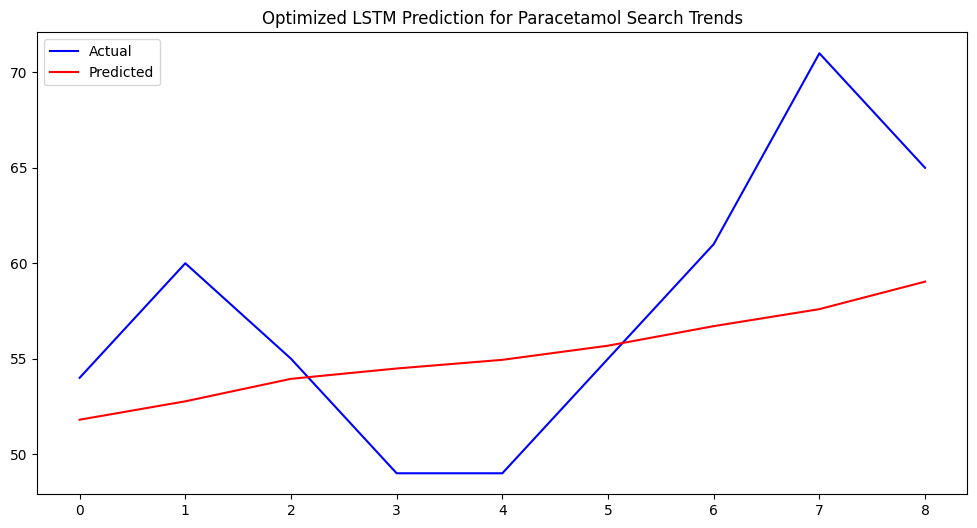

In [4]:
# Install dependencies
!pip install pytrends keras-tuner pandas tensorflow scikit-learn matplotlib seaborn

# ------------------ Import Libraries ------------------
from pytrends.request import TrendReq
import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt

# ------------------ Step 1: Fetch Google Trends Data ------------------
pytrends = TrendReq(hl='en-IN', tz=330)
medicines = ['Paracetamol','Ibuprofen','Aspirin','Cetirizine','Amoxicillin',
             'Metformin','Omeprazole','Azithromycin','Loratadine','Diclofenac']

timeframe = '2020-01-01 2025-09-25'

def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

all_time_data = pd.DataFrame()

for chunk in chunks(medicines, 5):
    pytrends.build_payload(chunk, timeframe=timeframe, geo='IN')
    df = pytrends.interest_over_time()
    if 'isPartial' in df.columns:
        df = df.drop(columns=['isPartial'])
    all_time_data = pd.concat([all_time_data, df], axis=1)
    time.sleep(1)

# Select top medicine
total_interest = all_time_data.sum().sort_values(ascending=False)
top_medicine = total_interest.index[0]
print(f"Top medicine: {top_medicine}")

# ------------------ Step 2: Prepare Data ------------------
SEQ_LENGTH = 60
data = all_time_data[top_medicine].values.reshape(-1,1)

scaler = MinMaxScaler(feature_range=(0,1))
data_scaled = scaler.fit_transform(data)

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X, y = create_sequences(data_scaled, SEQ_LENGTH)

# ------------------ Step 3: Define Model for Keras Tuner ------------------
def build_model(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=hp.Int('lstm_units', min_value=50, max_value=200, step=50),
                                 return_sequences=True, input_shape=(SEQ_LENGTH, 1))))
    model.add(Dropout(rate=hp.Float('dropout_rate1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Bidirectional(LSTM(units=hp.Int('lstm_units2', min_value=50, max_value=200, step=50))))
    model.add(Dropout(rate=hp.Float('dropout_rate2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(hp.Int('dense_units', min_value=20, max_value=100, step=20), activation='relu'))
    model.add(Dense(1))

    model.compile(
        optimizer='adam',
        loss='mean_squared_error'
    )
    return model

# ------------------ Step 4: Hyperparameter Tuning ------------------
tuner = kt.RandomSearch(
    build_model,
    objective='loss',
    max_trials=5,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='medicine_trends'
)

early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-5)

tuner.search(X, y, epochs=50, batch_size=32, callbacks=[early_stop, lr_reduction], verbose=1)

# ------------------ Step 5: Get Best Model ------------------
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters()[0]
print("Best Hyperparameters:")
print(best_hp.values)

# ------------------ Step 6: Train Final Model with Best Hyperparameters ------------------
batch_size = best_hp.get('batch_size') if 'batch_size' in best_hp.values else 32
best_model.fit(X, y, epochs=100, batch_size=batch_size, callbacks=[early_stop, lr_reduction], verbose=1)

# ------------------ Step 7: Predictions & Evaluation ------------------
predicted = best_model.predict(X)
predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(y)

rmse = np.sqrt(mean_squared_error(actual, predicted))
mae = mean_absolute_error(actual, predicted)
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# ------------------ Step 8: Visualization ------------------
plt.figure(figsize=(12,6))
plt.plot(actual, label="Actual", color="blue")
plt.plot(predicted, label="Predicted", color="red")
plt.title(f"Optimized LSTM Prediction for {top_medicine} Search Trends")
plt.legend()
plt.show()
